In [1]:
from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils
import utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

importlib.reload(utils)
importlib.reload(rt)

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import seaborn as sns

In [27]:
metro_end = gpd.read_parquet('./endpoint_delay_views/182_02_08_pm_peak.parquet')
metro_end = metro_end >> filter(_.arrival_hour >= 6, _.arrival_hour <= 22)

In [28]:
metro_seg = gpd.read_parquet('./segment_speed_views/182_02_08_pm_peak.parquet')

In [46]:
def chart_delays(filtered_view, name):
    '''
    A bar chart showing delays grouped by arrival hour for current filtered selection
    '''
    filtered_endpoint = filtered_view
    grouped = (filtered_endpoint >> group_by(_.arrival_hour)
               >> summarize(mean_end_delay = _.delay_seconds.mean())
              )
    grouped['Minutes of Delay at Endpoint'] = grouped.mean_end_delay / 60
    grouped['Hour'] = grouped.arrival_hour
    sns_plot = (sns.barplot(x=grouped['Hour'], y=grouped['Minutes of Delay at Endpoint'], ci=None, 
                   palette=[shared_utils.calitp_color_palette.CALITP_CATEGORY_BOLD_COLORS[1]])
        .set_title(f"{name} Mean Delays by Arrival Hour")
       )
    chart = sns_plot.get_figure()
    chart.tight_layout()
    return chart

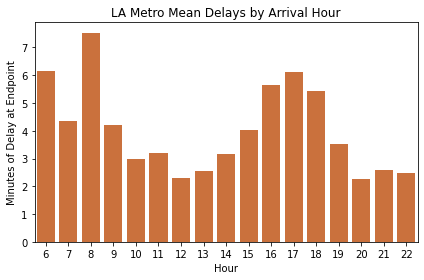

In [47]:
metro = chart_delays(metro_end, 'LA Metro')

In [31]:
modesto_end = gpd.read_parquet('./endpoint_delay_views/203_02_08_pm_peak.parquet')
modesto_end = modesto_end >> filter(_.arrival_hour >= 6, _.arrival_hour <= 22)

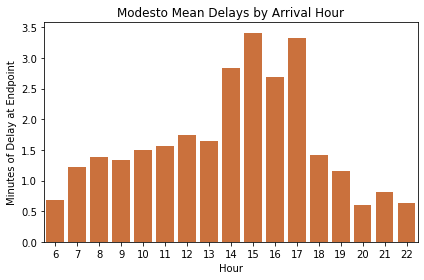

In [32]:
modesto = chart_delays(modesto_end, 'Modesto')

In [33]:
ac_end = gpd.read_parquet('./endpoint_delay_views/4_02_08_pm_peak.parquet')
ac_end = ac_end >> filter(_.arrival_hour >= 6, _.arrival_hour <= 22)

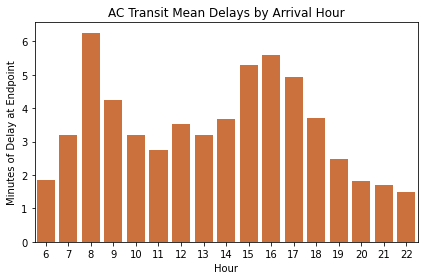

In [34]:
ac = chart_delays(ac_end, 'AC Transit')

In [35]:
metro.savefig('metro.png', bbox_inches='tight')

In [36]:
modesto.savefig('modesto.png', bbox_inches='tight')

In [37]:
ac.savefig('ac.png', bbox_inches='tight')

In [56]:
metro_seg.route_id.unique()

array(['154-13153', '602-13153', '487-13153', '28-13153', '211-13153',
       '106-13153', '40-13153', '210-13153', '294-13153', '224-13153',
       '60-13153', '237-13153', '117-13153', '804', '177-13153',
       '267-13153', '212-13153', '45-13153', '16-13153', '260-13153',
       '18-13153', '94-13153', '265-13153', '150-13153', '222-13153',
       '81-13153', '165-13153', '115-13153', '251-13153', '92-13153',
       '534-13153', '53-13153', '166-13153', '102-13153', '111-13153',
       '164-13153', '169-13153', '258-13153', '96-13153', '460-13153',
       '162-13153', '120-13153', '125-13153', '161-13153', '2-13153',
       '256-13153', '35-13153', '14-13153', '70-13153', '209-13153',
       '66-13153', '128-13153', '155-13153', '90-13153', '158-13153',
       '207-13153', '78-13153', '105-13153', '152-13153', '244-13153',
       '108-13153', '603-13153', '204-13153', '803', '218-13153',
       '232-13153', '4-13153', '242-13153', '167-13153', '130-13153',
       '180-13153', '217-

In [60]:
wilshire_wb = metro_seg >> filter(_.route_id == '720-13153', _.direction_id == '0')

In [72]:
sns.set(rc = {'figure.figsize':(10,6)})

Text(0.5, 1.0, 'LA Metro 720 PM Peak Eastbound Speeds (all segments)')

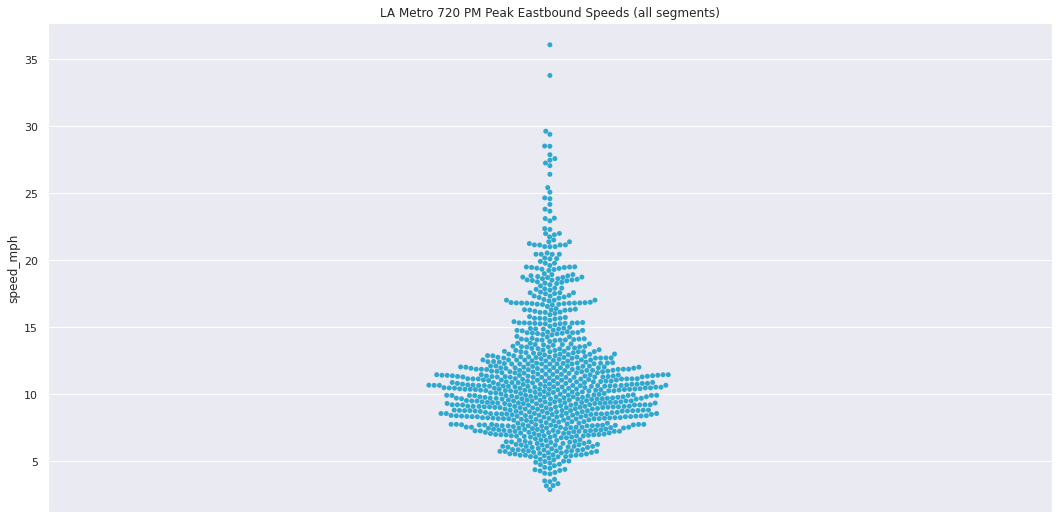

In [80]:
sns.swarmplot(y=wilshire_wb.speed_mph, palette=shared_utils.calitp_color_palette.CALITP_CATEGORY_BRIGHT_COLORS,
             size=5).set_title('LA Metro 720 PM Peak Eastbound Speeds (all segments)')

In [75]:
sns.set(rc = {'figure.figsize':(18,9)})

Text(0.5, 1.0, 'LA Metro 720 PM Peak Eastbound Speeds by Stop Segment')

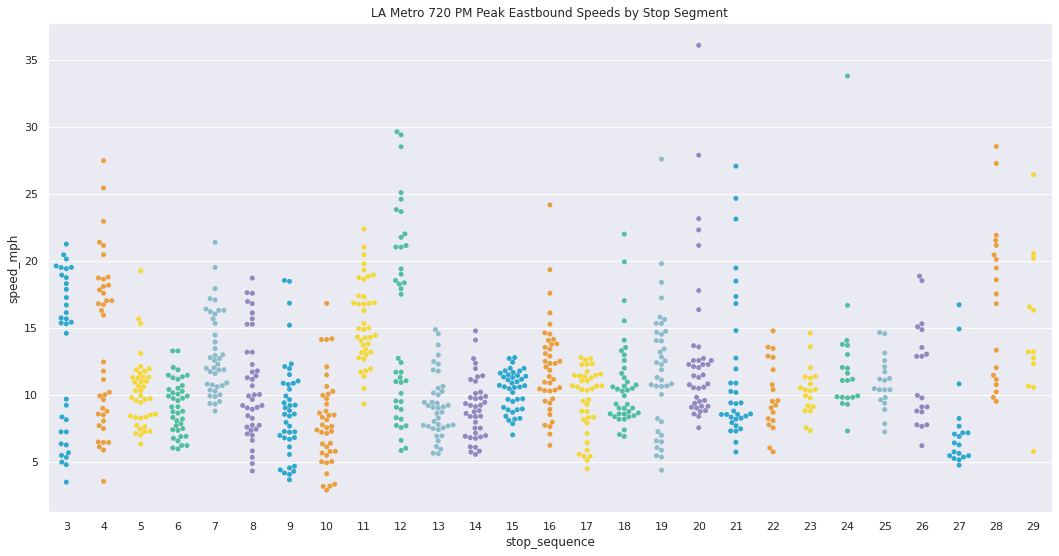

In [79]:
sns.swarmplot(x= wilshire_wb.stop_sequence,y=wilshire_wb.speed_mph,
              palette=shared_utils.calitp_color_palette.CALITP_CATEGORY_BRIGHT_COLORS,
             ).set_title('LA Metro 720 PM Peak Eastbound Speeds by Stop Segment')

In [81]:
mod_seg = gpd.read_parquet('./segment_speed_views/203_02_08_pm_peak.parquet')

In [83]:
_28_sb = mod_seg >> filter(_.route_id == '28', _.direction_id == '1')

In [92]:
sns.set(rc = {'figure.figsize':(13,6)})

In [93]:
_28_sb = _28_sb.rename(columns={'speed_mph': 'Segement Speed (mph)',
                               'stop_sequence': 'Stop Segment ID'})

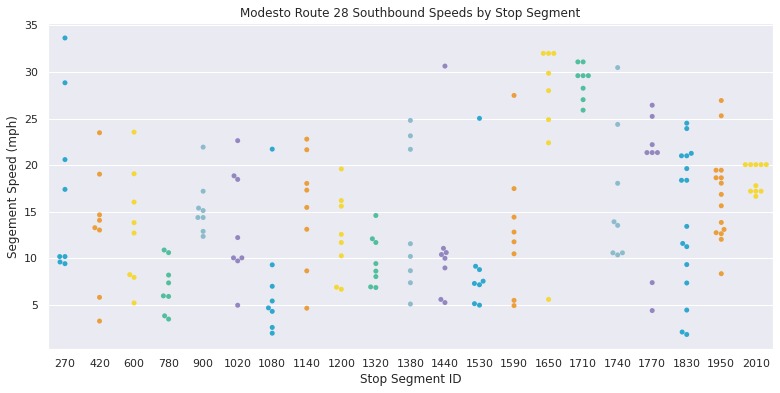

In [98]:
plt = sns.swarmplot(x = _28_sb['Stop Segment ID'], y=_28_sb['Segement Speed (mph)'],
              palette=shared_utils.calitp_color_palette.CALITP_CATEGORY_BRIGHT_COLORS,
             ).set_title('Modesto Route 28 Southbound Speeds by Stop Segment')

In [99]:
chart = plt.get_figure()
chart.tight_layout()

In [100]:
chart.savefig('modesto_segments.png', bbox_inches='tight')